In [1]:
from __future__ import print_function
import sys, os
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'..')))
from getdist import plots, loadMCSamples, MCSamples
import getdist
import matplotlib.pyplot as plt
import IPython
from matplotlib import rc
#import seaborn as sns
import pandas as pd
import numpy as np
from scipy.special import gamma, factorial, erfinv
import scipy.integrate as integrate
from scipy.integrate import quad
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import os,sys
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

c=299792.458

from Theory_class import TheoryCalculator
from Data import *

In [2]:
# Theory and Data calculating functions
theory = TheoryCalculator()
data = Data()

In [3]:
# Importing data 

# SN data points
mu_obs_SN=data.SN()
# DESI BAO data points
mu_obs_DESI=data.BAO()
# SDSS BAO data points
mu_obs_SDSS=data.SDSS()

/Users/elsateixeira/Library/CloudStorage/GoogleDrive-elsa.teixeira.14@gmail.com/My Drive/Projects/cosmo_codes/CLASS/class_ddr/DDR_FIGURES/Data.py:21: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  self.mu_obs_SN = pd.read_csv(self.SN_path, delim_whitespace=True, comment='#', names=['z', 'data', 'error'])


In [4]:
# Define parameter values in a structured dictionary
cosmo_param_values = {
    'eta': [5., 5., 5.],
    'a0': [0., -0.134, -0.134],
    'a1': [0., -0.040, -0.040],
    'w0': [-1.155 ,-1, -1.155],
    'wa': [-0.09, 0., -0.09],
    'H0': [0.7277,0.7277,0.7277],
    'ombh2': [0.02238,0.02238,0.02238],
    'omch2': [0.1199,0.1199,0.1199],
    'As': [3.045,3.045,3.045],
    'ns': [0.9657,0.9657,0.9657],
    'tau': [0.0546,0.0546,0.0546],
    'zstar': [0.9, 0.9, 0.9],
    'M': [-19.264,-19.264,-19.264]  
}

# Compute deltaM_SH0ES_Planck
deltaM_SH0ES_Planck = -19.253 - cosmo_param_values['M'][0]

# Generate the list of cosmological models
cosmo_params = [
    {
        key: (np.exp(value) * 1e-10 if key == 'As' else (value * 100 if key == 'H0' else value))
        for key, value in zip(cosmo_param_values.keys(), values)
        if key != 'M'  # Evita di includere 'M' nel dizionario finale
    }
    for values in zip(*cosmo_param_values.values())
]


# Initialize storage arrays

#number of things
num_models = len(cosmo_params) #WG: number of models
num_SN = len(mu_obs_SN['z']) #WG: number of SN
num_DESI = len(mu_obs_DESI['z']) #WG: number of DESI BAO
num_SDSS = len(mu_obs_SDSS['z']) #WG: number of SDSS BAO

delta_mu_SN_ddr_array = np.zeros((num_models, num_SN))
delta_mu_DESI_array = np.zeros((num_models, num_DESI))
delta_mu_SDSS_array = np.zeros((num_models, num_SDSS))

z = np.linspace(0.0010,4,1000)
len_z=int(len(z))

#WG: Inizialize SN arrays for theory
mu_th_SN_pl = np.zeros( (num_models, len_z) ) 
delta_mu_SN_pl = np.zeros( (num_models, len_z) )  
mu_obs_SN_ddr_Planck = np.zeros( (num_models, len_z) )
delta_mu_SN_min_pl = np.zeros( (num_models, len_z) )
delta_mu_SN_max_pl = np.zeros( (num_models, len_z) )

#WG: Inizialize BAO arrays for theory
mu_th_pl = np.zeros( (num_models, len_z) ) 
mu_th_DESI_pl = np.zeros( (num_models, len_z) )
delta_mu_DESI_pl = np.zeros( (num_models, len_z) )
delta_mu_DESI_min_pl = np.zeros( (num_models, len_z) )
delta_mu_DESI_max_pl = np.zeros( (num_models, len_z) )


for i, params in enumerate(cosmo_params):
    
    #WG this inzialize the class TheoryCalculator in Thery_class.py
    theory = TheoryCalculator(**params)
    
    # ==================== Supernovae Data-points ======================================================
    
    #WG: this gets \mu(z) when DL(z) = (1+z)^2 \eta(z) DA(z) at the redshifts observed by SN
    mu_th_SN_ddr = np.array([theory.get_distance_moduli_ddr(_z) for _z in mu_obs_SN['z']])
    
    #WG: this gets \mu(z) when DL(z) = (1+z)^2 DA(z) [i.e., eta(z)=1] at the redshifts observed by SN
    mu_th_SN = np.array([theory.get_distance_moduli(_z) for _z in mu_obs_SN['z']])
    
    #WG: this gets the difference \delta_mu(z)=5 log10(\eta(z)) between the two cases
    mu_th_SN_diff = mu_th_SN_ddr - mu_th_SN
  
    #WG: here we shift the observed SN datapoints by the correction given by the DDR violation
    mu_obs_SN_ddr = mu_obs_SN['data'] - mu_th_SN_diff
    
    #WG: this renormalize the re-shefited data to the theretical prediction 
    delta_mu_SN_ddr = mu_obs_SN_ddr - mu_th_SN
    
    #WG: store results in arrays
    delta_mu_SN_ddr_array[i] = delta_mu_SN_ddr 
    
    # ==================== BAO Data-points ======================================================
    
    #WG: this gives \mu(z) at the redshift observed by DESI
    mu_th_DESI = np.array([theory.get_distance_moduli(z) for z in mu_obs_DESI['z']])
    
    #WG: this gives \mu(z) at the redshift observed by SDSS 
    mu_th_SDSS = np.array([theory.get_distance_moduli(z) for z in mu_obs_SDSS['z']])
    
    #WG: this renormalize the data to the theretical prediction for DESI 
    delta_mu_DESI = mu_obs_DESI['data'] - mu_th_DESI
    delta_mu_DESI_array[i] = delta_mu_DESI #WG: store results in arrays
    
    #WG: this renormalize the data to the theretical prediction for SDSS
    delta_mu_SDSS = mu_obs_SDSS['data'] - mu_th_SDSS
    delta_mu_SDSS_array[i] = delta_mu_SDSS #WG: store results in arrays
    
    # ==================== BAO Theoretical Rescale ======================================================
    
    #WG: mu(z) observed by DESI
    mu_th_DESI_pl[i] = np.array([theory.get_distance_moduli(_zz) for _zz in z])
    
    #WG: mu(z) observed by Planck
    mu_th_pl[i] = np.array([theory.get_distance_moduli(_zz) for _zz in z])

    # Calculate the difference (which will be zero by construction)
    delta_mu_DESI_pl[i] = mu_th_DESI_pl[i] - mu_th_DESI_pl[i]

    # Error bars for line given the rs error
    delta_mu_DESI_min_pl[i] = -( 5/(147.09*np.log(10) ) )*0.26
    delta_mu_DESI_max_pl[i] = ( 5/(147.09*np.log(10) ) )*0.26
    
    # ==================== SN Theoretical Rescal ======================================================

    #WG: calculate \mu(z) when DL(z) = (1+z)^2 \eta(z) DA(z)
    mu_th_SN_pl[i] = np.array([theory.get_distance_moduli_ddr(_zz) for _zz in z])

    # Calculate how the shift in \Delta D_L caused by the difference in M between SH0ES and Planck 
    # (first panel in the plot) 
    # changes by breking the DDR (other panels in the fig. for different models)
    delta_mu_SN_pl[i] = -(mu_th_SN_pl[i] - mu_th_DESI_pl[i])  - deltaM_SH0ES_Planck

    # Error bars for the line given the M error
    delta_mu_SN_min_pl[i] = mu_th_DESI_pl[i] - mu_th_SN_pl[i] - 0.027 - deltaM_SH0ES_Planck
    delta_mu_SN_max_pl[i] = mu_th_DESI_pl[i] - mu_th_SN_pl[i] + 0.027 - deltaM_SH0ES_Planck

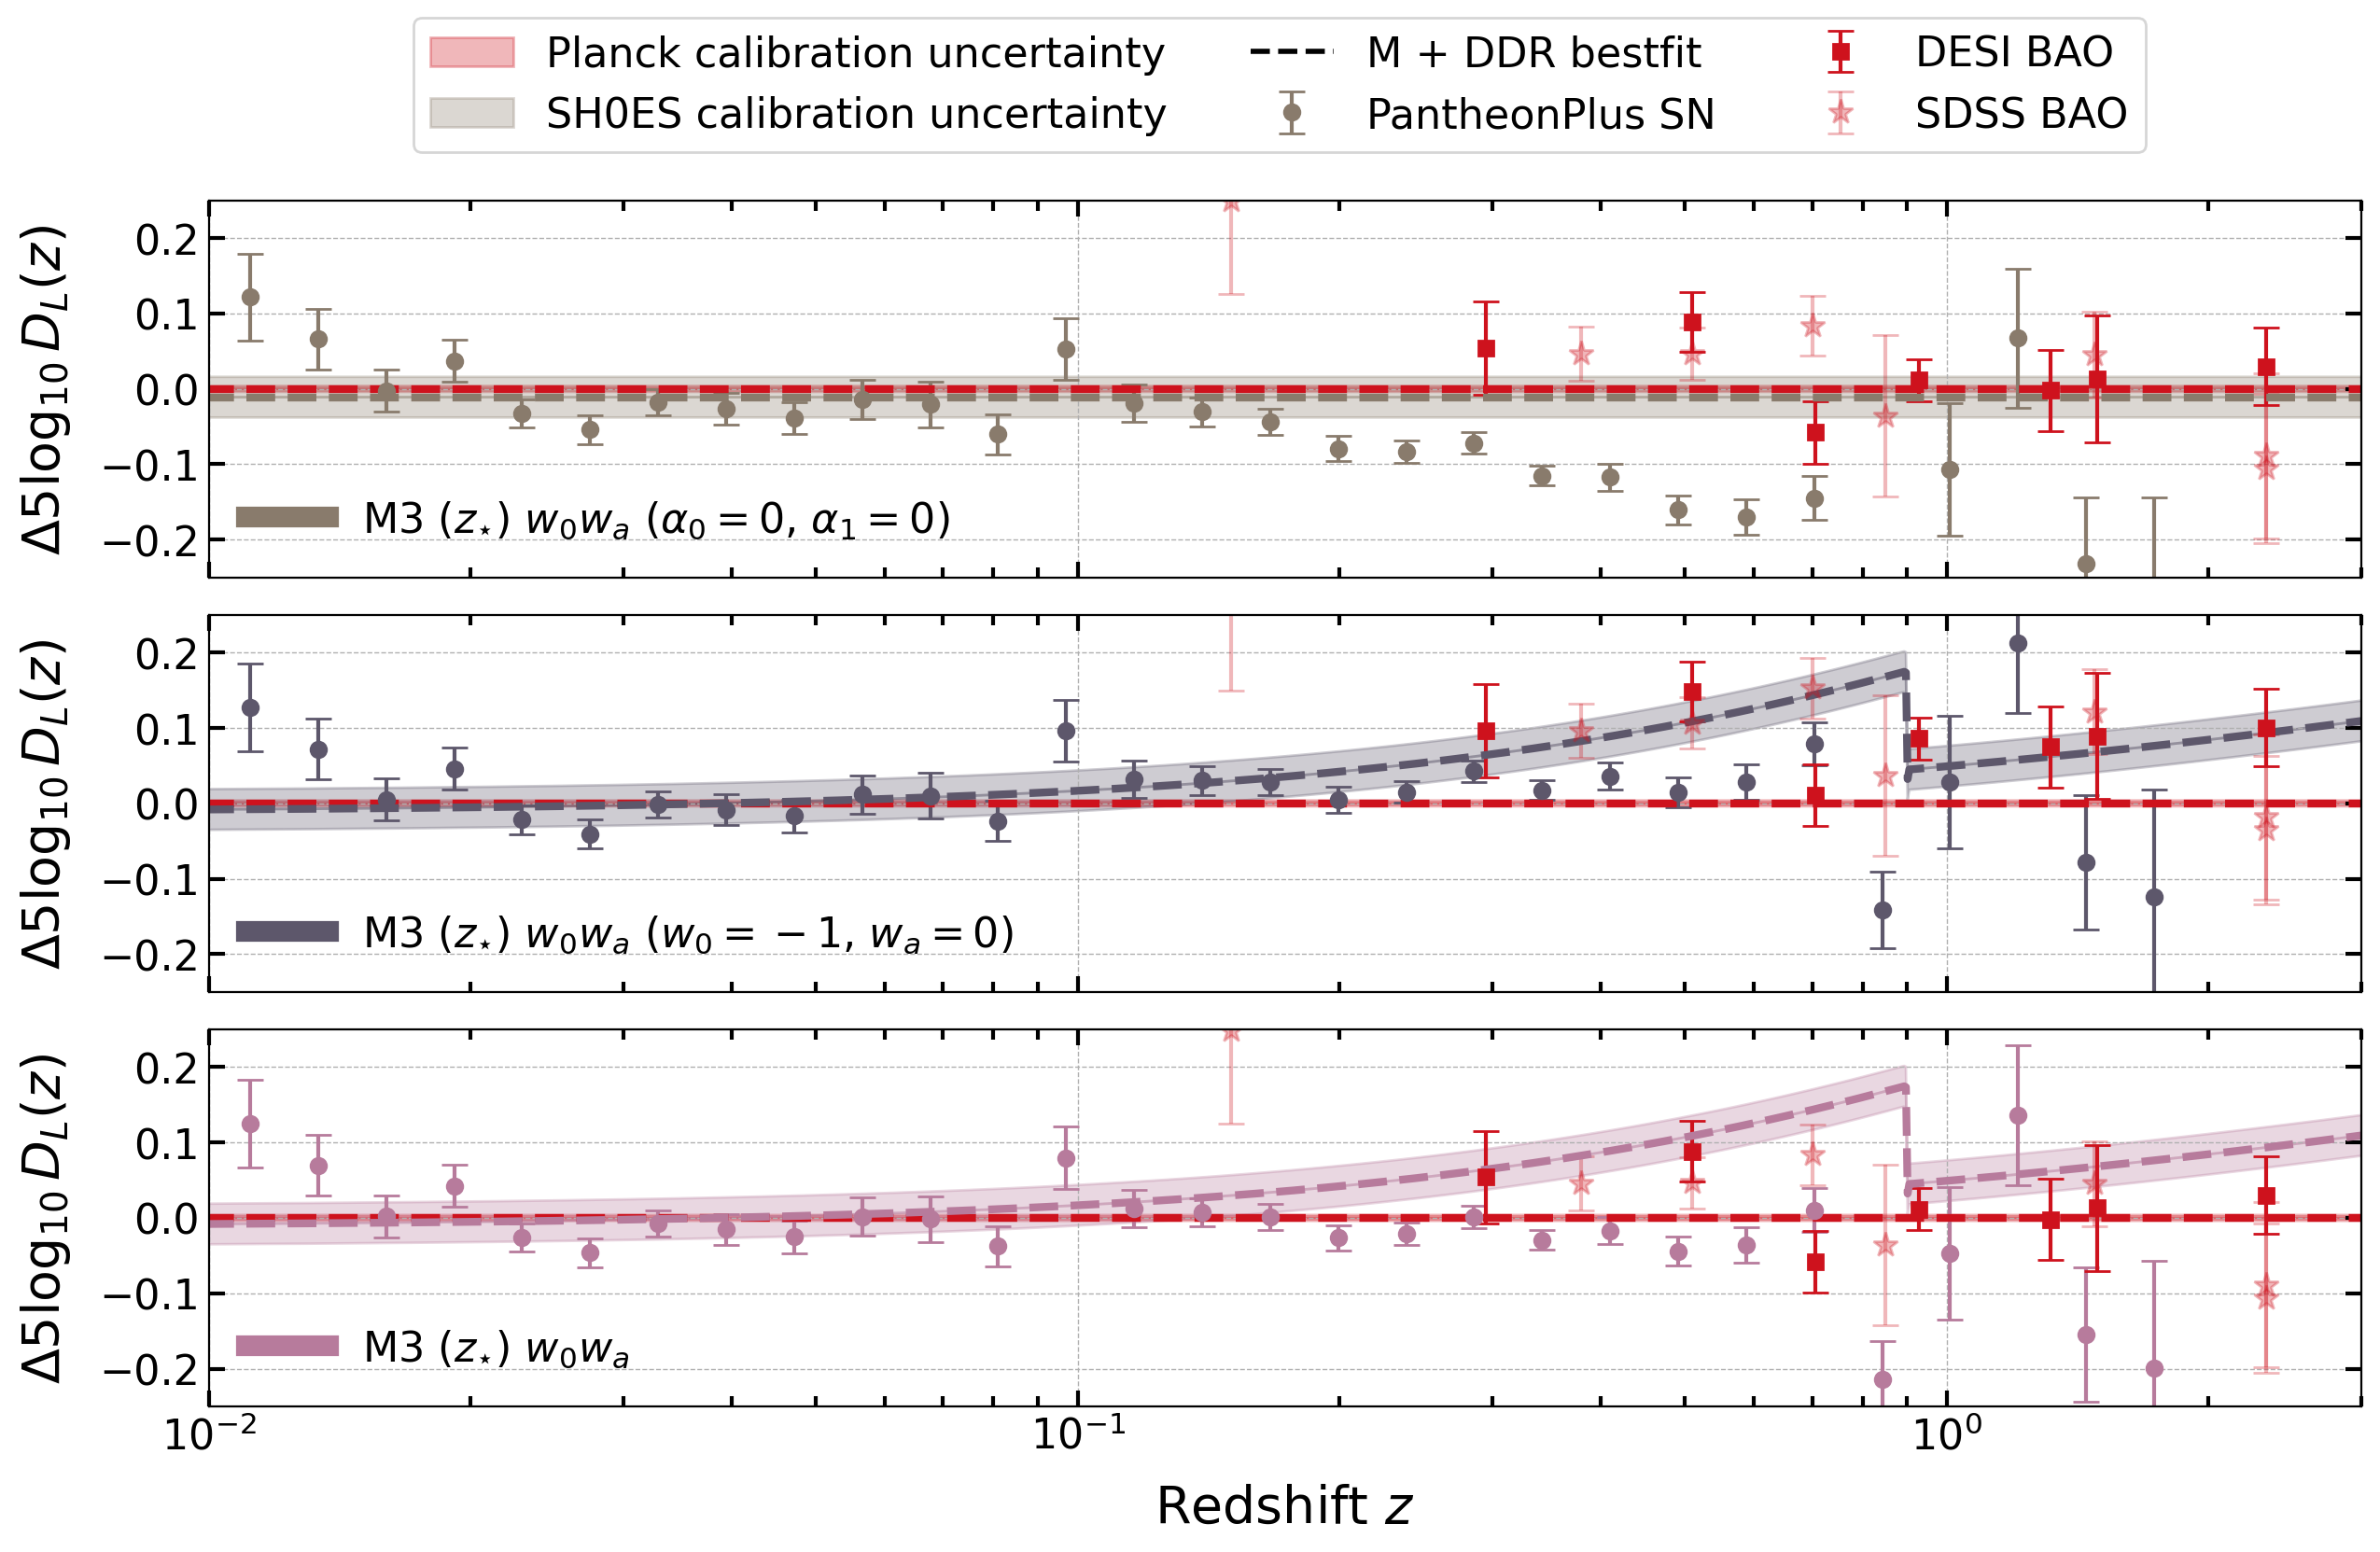

In [5]:
import matplotlib.pyplot as plt

lw = 3
rr = '#CE121D'  # Red color for BAO
bb = '#6871F7'  # Blue color for SN

#aa = '#CE121D'
aa = '#C39BE9' #violet
#aa = '#EA85AF'
bb = '#ED9107' #orange
cc = '#9C99FF' #blue
dd = '#5D576B' #grey
ee = '#EEE5E9' #beige
ff = '#7FD1B9' #green
gg = '#DBA159' #yellow
hh = '#B77B9C' #magenta
ii = '#7594FA' #blue
ddd = '#897B6C'

#colors = [dd,cc,aa,gg,ff,hh]
colors = [ddd,dd,hh]
labels = [r'M3 ($z_{\star}$) $w_0w_a$ ($\alpha_0=0$, $\alpha_1=0$)',r'M3 ($z_{\star}$) $w_0w_a$ ($w_0=-1$, $w_a=0$)', r'M3 ($z_{\star}$) $w_0w_a$']

fig, axes = plt.subplots(3, 1, figsize=(13, 8), sharex=True)

for i, ax in enumerate(axes):
    ax.set_xscale('log')
    ax.set_yscale('linear')

    ax.set_ylabel(r'$\Delta5\log_{10} D_L(z)$', size=20, labelpad=10)
    ax.grid(lw=0.5, ls='--')

    # Plot with error bars for each index
    ax.errorbar(mu_obs_SN['z'], delta_mu_SN_ddr_array[i], yerr=mu_obs_SN['error'], fmt='o', capsize=5, label='PantheonPlus SN', color=colors[i])
    ax.errorbar(mu_obs_DESI['z'], delta_mu_DESI_array[i], yerr=mu_obs_DESI['error'], fmt='s', capsize=5, label='DESI BAO', color=rr)
    ax.errorbar(mu_obs_SDSS['z'], delta_mu_SDSS_array[i], yerr=mu_obs_SDSS['error'], fmt='*', capsize=5, markersize=10, label='SDSS BAO', color=rr, alpha=0.3)

    # Plot theoretical lines 
    ax.plot(z, delta_mu_DESI_pl[i], c=rr, lw=lw, ls='--')
    ax.fill_between(z, delta_mu_DESI_pl[i], delta_mu_DESI_max_pl[i], where=(delta_mu_DESI_max_pl[i] > delta_mu_DESI_pl[i]), color=rr, alpha=0.3,label='Planck calibration uncertainty')
    ax.fill_between(z, delta_mu_DESI_pl[i], delta_mu_DESI_min_pl[i], where=(delta_mu_DESI_min_pl[i] < delta_mu_DESI_pl[i]), color=rr, alpha=0.3)

    ax.plot(z, delta_mu_SN_pl[i], c=colors[i], lw=lw, ls='--')
    ax.fill_between(z, delta_mu_SN_pl[i], delta_mu_SN_max_pl[i], where=(delta_mu_SN_max_pl[i] > delta_mu_SN_pl[i]), color=colors[i], alpha=0.3,label='SH0ES calibration uncertainty')
    ax.fill_between(z, delta_mu_SN_pl[i], delta_mu_SN_min_pl[i], where=(delta_mu_SN_min_pl[i] < delta_mu_SN_pl[i]), color=colors[i], alpha=0.3)

    # Add label
    ax.plot(z + 5, 100 * delta_mu_SN_pl[i], c='k', lw=2, ls='--', label=r'M + DDR bestfit')

    ax.tick_params(axis='both', which='both', labelsize=16)
    ax.xaxis.set_tick_params(which='major', size=6, width=1.5, direction='in', top=True)
    ax.xaxis.set_tick_params(which='minor', size=4, width=1.5, direction='in', top=True)
    ax.yaxis.set_tick_params(which='major', size=6, width=1.5, direction='in', right=True)
    ax.yaxis.set_tick_params(which='minor', size=4, width=1.5, direction='in', right=True)

    ax.set_xlim(0.01, 3)
    ax.set_ylim(-0.25, 0.25)  # Y-axis limit updated
    ax.set_yticks([-0.2, -0.1, 0, 0.1, 0.2])  # Set specific ticks at -0.2, -0.1, 0, 0.1, 0.2 (to evaluate)

    # Set individual model labels
    handle = ax.plot([], [], color=colors[i], lw=8, label=labels[i])[0]
    ax.legend([handle], [labels[i]], loc='lower left', fontsize=16, frameon=False)

# Set x-label only for the last subplot
axes[-1].set_xlabel(r'Redshift $z$', size=20, labelpad=10)

plt.rcParams['font.size'] = 14
plt.rcParams['axes.linewidth'] = 2
handles, labels = axes[0].get_legend_handles_labels()
new_handles = [handles[0],handles[1],handles[2],handles[4],handles[5],handles[6]]
new_labels = [labels[0],labels[1],labels[2],labels[4],labels[5],labels[6]]
fig.legend(new_handles, new_labels, loc='upper center', ncol=3, fontsize=16, frameon=True,bbox_to_anchor=(0.038, 1.01, 1, 0.05))
fig.tight_layout(rect=[0, 0, 1, 0.95])  # Leaves space for the legend
fig.subplots_adjust(hspace=0.1)  # Increased hspace for more spacing between subplots
plt.savefig('sn_bao_m3_prior_panels.pdf', transparent=True, bbox_inches='tight', pad_inches=0.1)
plt.show()
